In [ ]:
!pip3 install networkx

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [ ]:
!pip install matplotlib
!pip install geopandas==0.14.4
!pip install fiona==1.9.6
!pip install geodatasets
!pip install scipy

In [25]:
import networkx as nx
import pandas as pd
import sys
import time
from networkx.algorithms.clique import find_cliques

In [26]:
data_path = ''

In [27]:
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# Load the datasets
airport_columns = [
    'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',
    'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
    'Tz Database Timezone', 'Type', 'Source'
]

route_columns = [
    'Airline', 'Airline ID', 'Source', 'Source ID', 'Destination',
    'Destination ID', 'Codeshare', 'Stops', 'Equipment'
]

def load_dataset(file_path, columns):
    return pd.read_csv(file_path, header=None, names=columns)

# Preprocess the data
def preprocess_graph(airports, routes):
    # Filter valid airports
    valid_airports = set(airports['Airport ID'].astype(str))

    # Build a graph
    G = nx.Graph()

    # Add nodes
    for _, row in airports.iterrows():
        G.add_node(row['Airport ID'], name=row['Name'], country=row['Country'],
                   latitude=row['Latitude'], longitude=row['Longitude'])

    # Add edges (routes)
    for _, row in routes.iterrows():
        if row['Source ID'] in valid_airports and row['Destination ID'] in valid_airports:
            G.add_edge(row['Source ID'], row['Destination ID'])

    return G



In [ ]:
airports = pd.read_csv('cleaned_airports.csv')
routes = pd.read_csv('cleaned_routes.csv')
routes = pd.merge(airports[['IATA']],routes,left_on='IATA',right_on='Source')
routes = pd.merge(airports[['IATA']],routes,left_on='IATA',right_on='Destination')
# Visualize the data preview
display(airports.head())
display(routes.head())

# Direct graph creation with NetworkX
G = nx.Graph()

# Add nodes
for index, row in airports.iterrows():
    G.add_node(row['IATA'], name=row['Name'], city=row['City'], country=row['Country'],
                   latitude=row['Latitude'], longitude=row['Longitude'])

# Add edges
for index, row in routes.iterrows():
    G.add_edge(row['Source'], row['Destination'])

# Information on the Graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
# Create the graph



,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz Database Timezone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


,IATA_x,IATA_y,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment
0,GKA,MAG,CG,1308,MAG,2,GKA,1,NaN,0,DH8
1,GKA,HGU,CG,1308,HGU,3,GKA,1,NaN,0,DH8 DHT
2,GKA,LAE,CG,1308,LAE,4,GKA,1,NaN,0,DH8
3,GKA,POM,CG,1308,POM,5,GKA,1,NaN,0,DH8
4,GKA,POM,PX,328,POM,5,GKA,1,NaN,0,DH4 DH8 DH3


Number of nodes: 6072
Number of edges: 18931


Number of cliques found: 21327
Number of communities detected: 40


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


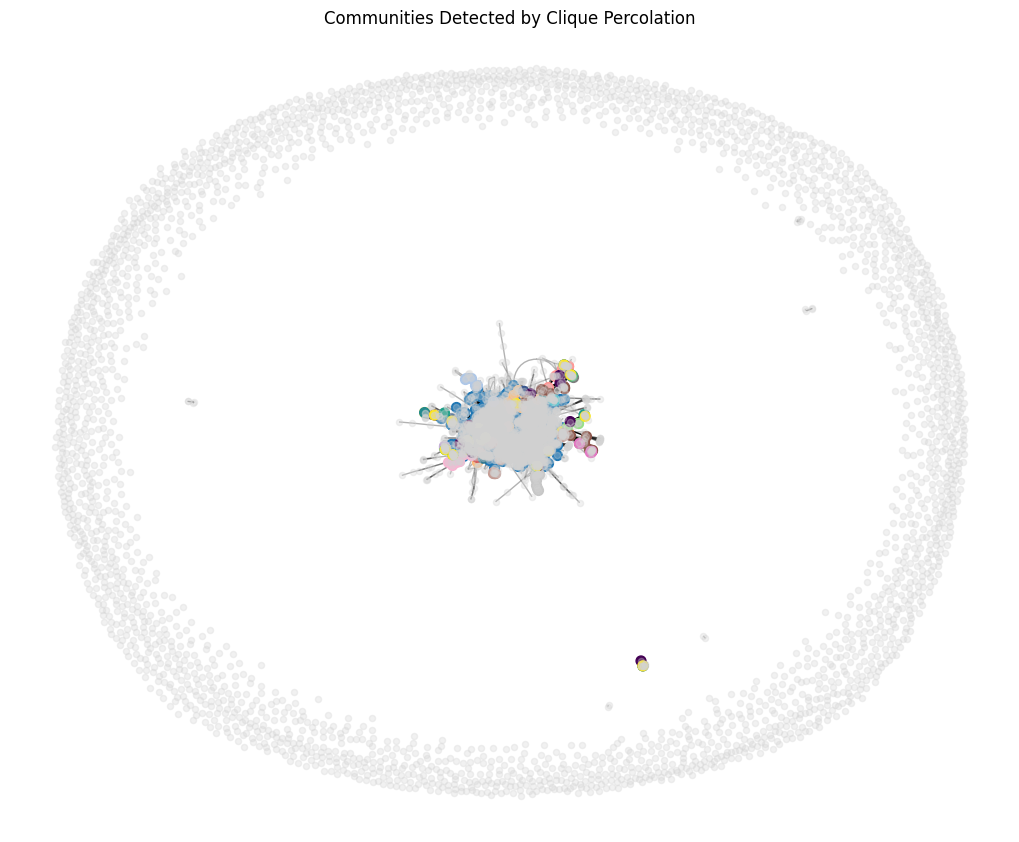

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

def find_cliques(G, size):
    """
    Find all cliques of a given size in the graph.
    """
    cliques = [clique for clique in nx.find_cliques(G) if len(clique) >= size]
    return cliques

def build_clique_graph(cliques, size):
    """
    Build the clique graph where nodes represent cliques,
    and edges represent shared nodes between cliques.
    """
    clique_graph = nx.Graph()
    for i, clique1 in enumerate(cliques):
        for j, clique2 in enumerate(cliques):
            if i < j and len(set(clique1).intersection(set(clique2))) >= size - 1:
                clique_graph.add_edge(i, j)
    return clique_graph

def extract_communities(clique_graph, cliques):
    """
    Extract communities from the connected components of the clique graph.
    """
    communities = []
    for component in nx.connected_components(clique_graph):
        community = set()
        for clique_index in component:
            community.update(cliques[clique_index])
        communities.append(community)
    return communities

def draw_community_graph(G, communities):
    """
    Draw the original graph with communities highlighted.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    for i, community in enumerate(communities):
        nx.draw(
            G.subgraph(community),
            pos,
            node_size=50,
            node_color=plt.cm.tab20(i / len(communities)),
            with_labels=False
        )
    nx.draw(G, pos, node_color="lightgray", node_size=20, alpha=0.3, with_labels=False)
    plt.title("Communities Detected by Clique Percolation")
    plt.show()

# Parameters
k = 3  # Clique size
# Step 1: Find cliques of size z
cliques = find_cliques(G, k)
print(f"Number of cliques found: {len(cliques)}")

# Step 2: Build the clique graph
clique_graph = build_clique_graph(cliques, k)

# Step 3: Extract communities
communities = extract_communities(clique_graph, cliques)
print(f"Number of communities detected: {len(communities)}")

# Step 4: Draw the community graph
draw_community_graph(G, communities)


In [ ]:
partition = {}
for commun,l in enumerate(communities):
  for country in l:
    partition[country]=commun


In [ ]:
# Assign community labels to nodes
nx.set_node_attributes(G, partition, "community")


In [ ]:
# Assuming 'G' is your NetworkX graph and it has a 'community' attribute for each node.

for node, data in G.nodes(data=True):
    if 'community' not in data or data['community'] is None:
        data['community'] = -1  # Assign -1 to nodes with missing or None community

# Example of accessing updated communities
# for node, data in G.nodes(data=True):
#     print(f"Node: {node}, Community: {data['community']}")

In [ ]:
graph_data = []
for node, attributes in G.nodes(data=True):
    attributes['Node'] = node
    graph_data.append(attributes)

pd.DataFrame(graph_data)

,name,city,country,latitude,longitude,community,Node
0,Goroka Airport,Goroka,Papua New Guinea,-6.081690,145.391998,0,GKA
1,Madang Airport,Madang,Papua New Guinea,-5.207080,145.789001,0,MAG
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,-5.826790,144.296005,0,HGU
3,Nadzab Airport,Nadzab,Papua New Guinea,-6.569803,146.725977,0,LAE
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,-9.443380,147.220001,0,POM
...,...,...,...,...,...,...,...
6067,Bilogai-Sugapa Airport,Sugapa-Papua Island,Indonesia,-3.739560,137.031998,-1,UGU
6068,Ramon Airport,Eilat,Israel,29.723694,35.011416,-1,ETM
6069,Rustaq Airport,Al Masna'ah,Oman,23.640556,57.487500,-1,MNH
6070,Laguindingan Airport,Cagayan de Oro City,Philippines,8.612203,124.456496,0,CGY


<ipython-input-22-af7c715ba5be>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_communities))  # Use a colormap with enough unique colors


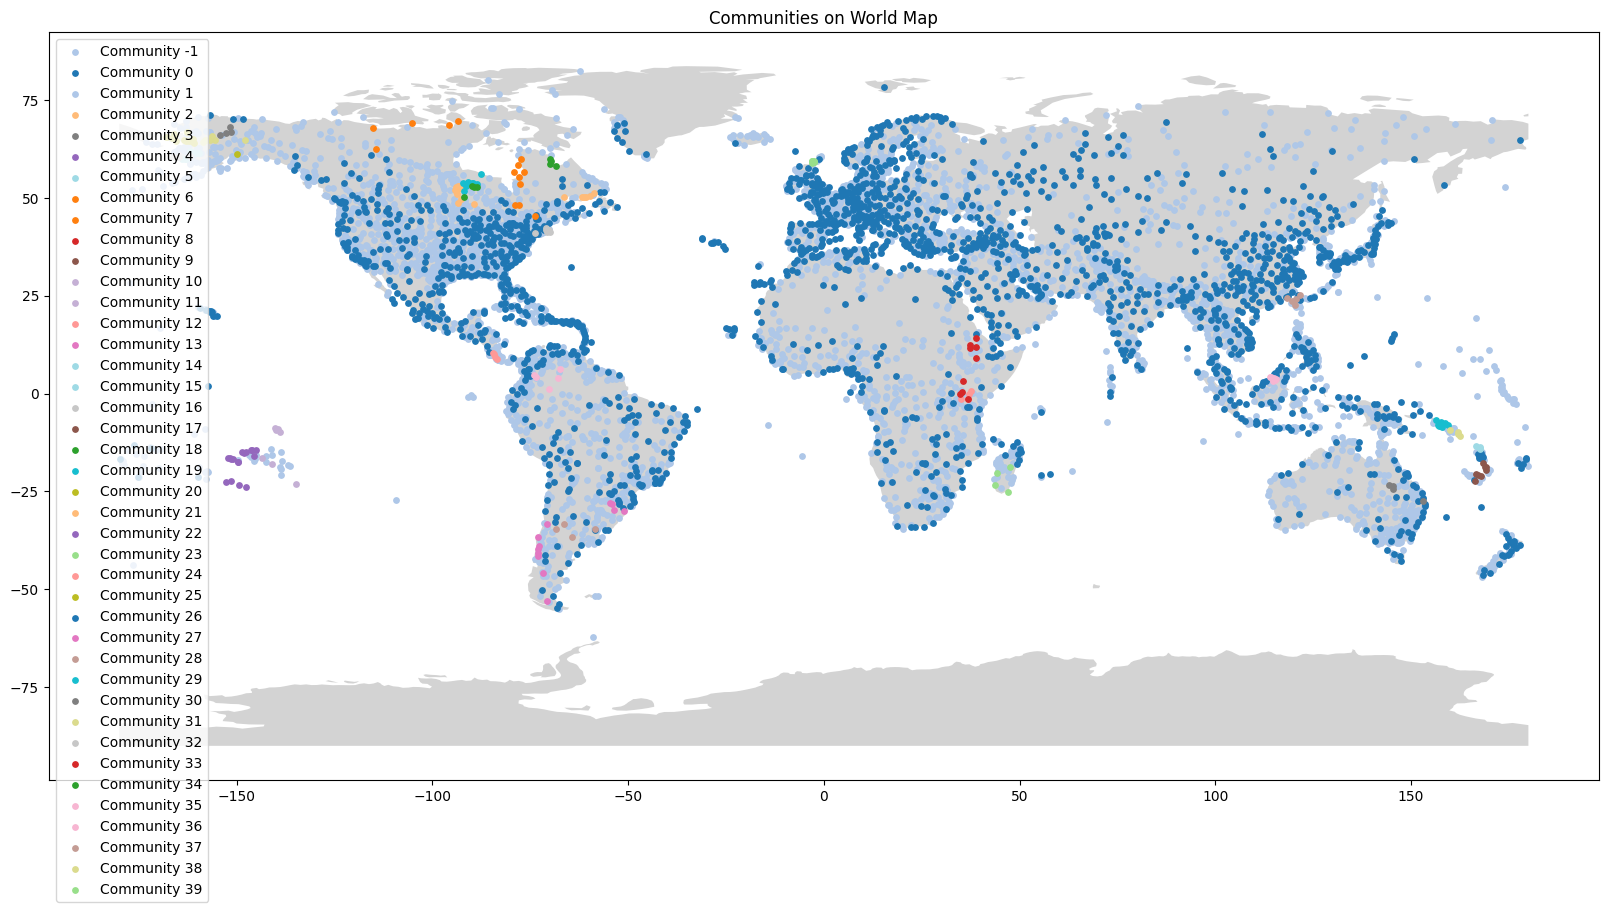

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

df = pd.DataFrame(graph_data)
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Load world map
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

# Generate unique colors for each community
unique_communities = gdf['community'].unique()
color_map = plt.cm.get_cmap('tab20', len(unique_communities))  # Use a colormap with enough unique colors
community_colors = {community: color_map(i) for i, community in enumerate(unique_communities)}

# Plot the map
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(ax=ax, color='lightgray')  # Plot world map in the background

# Plot each community with a unique color
for community, color in sorted(community_colors.items()):
    subset = gdf[gdf['community'] == community]
    subset.plot(ax=ax, marker='o', color=color, markersize=15, label=f"Community {community}")

# Add legend and show plot
plt.legend()
plt.title("Communities on World Map")
plt.show()


In [31]:

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

for community in df['community'].unique():
    community_nodes = df[df['community'] == community].Node.tolist()
    max_closeness_centrality = 0
    central_node = None
    for node in community_nodes:
        if closeness_centrality[node] > max_closeness_centrality:
            max_closeness_centrality = closeness_centrality[node]
            central_node = node

    if central_node:
        central_node_data = df[df.Node == central_node]
        print(f"Community {community} center (Closeness Centrality): {central_node_data['name'].iloc[0]} (Longitude={central_node_data['longitude'].iloc[0]}, Latitude={central_node_data['latitude'].iloc[0]})")


Community 0 center (Closeness Centrality): Frankfurt am Main Airport (Longitude=8.570556, Latitude=50.033333)
Community 26 center (Closeness Centrality): Kangerlussuaq Airport (Longitude=-50.7116031647, Latitude=67.0122218992)
Community -1 center (Closeness Centrality): Ovda International Airport (Longitude=34.93579864501953, Latitude=29.94029998779297)
Community 1 center (Closeness Centrality): Winnipeg / James Armstrong Richardson International Airport (Longitude=-97.2398986816, Latitude=49.9099998474)
Community 6 center (Closeness Centrality): Yellowknife Airport (Longitude=-114.44000244140624, Latitude=62.462799072265625)
Community 7 center (Closeness Centrality): Montreal / Pierre Elliott Trudeau International Airport (Longitude=-73.7407989502, Latitude=45.4706001282)
Community 21 center (Closeness Centrality): Thunder Bay Airport (Longitude=-89.32389831542969, Latitude=48.37189865112305)
Community 2 center (Closeness Centrality): Sept-Îles Airport (Longitude=-66.2656021118164, La

In [32]:
import matplotlib.colors as mcolors

def darken_color(color, factor=0.8):
  """Darkens a color by a given factor.

  Args:
    color: A tuple representing the RGBA color (e.g., (0.6, 0.8, 0.9, 1.0)).
    factor: The factor to darken the color by (0.0 to 1.0).

  Returns:
    A tuple representing the darkened RGBA color.
  """
  r, g, b, a = color
  return (r * factor, g * factor, b * factor, a)

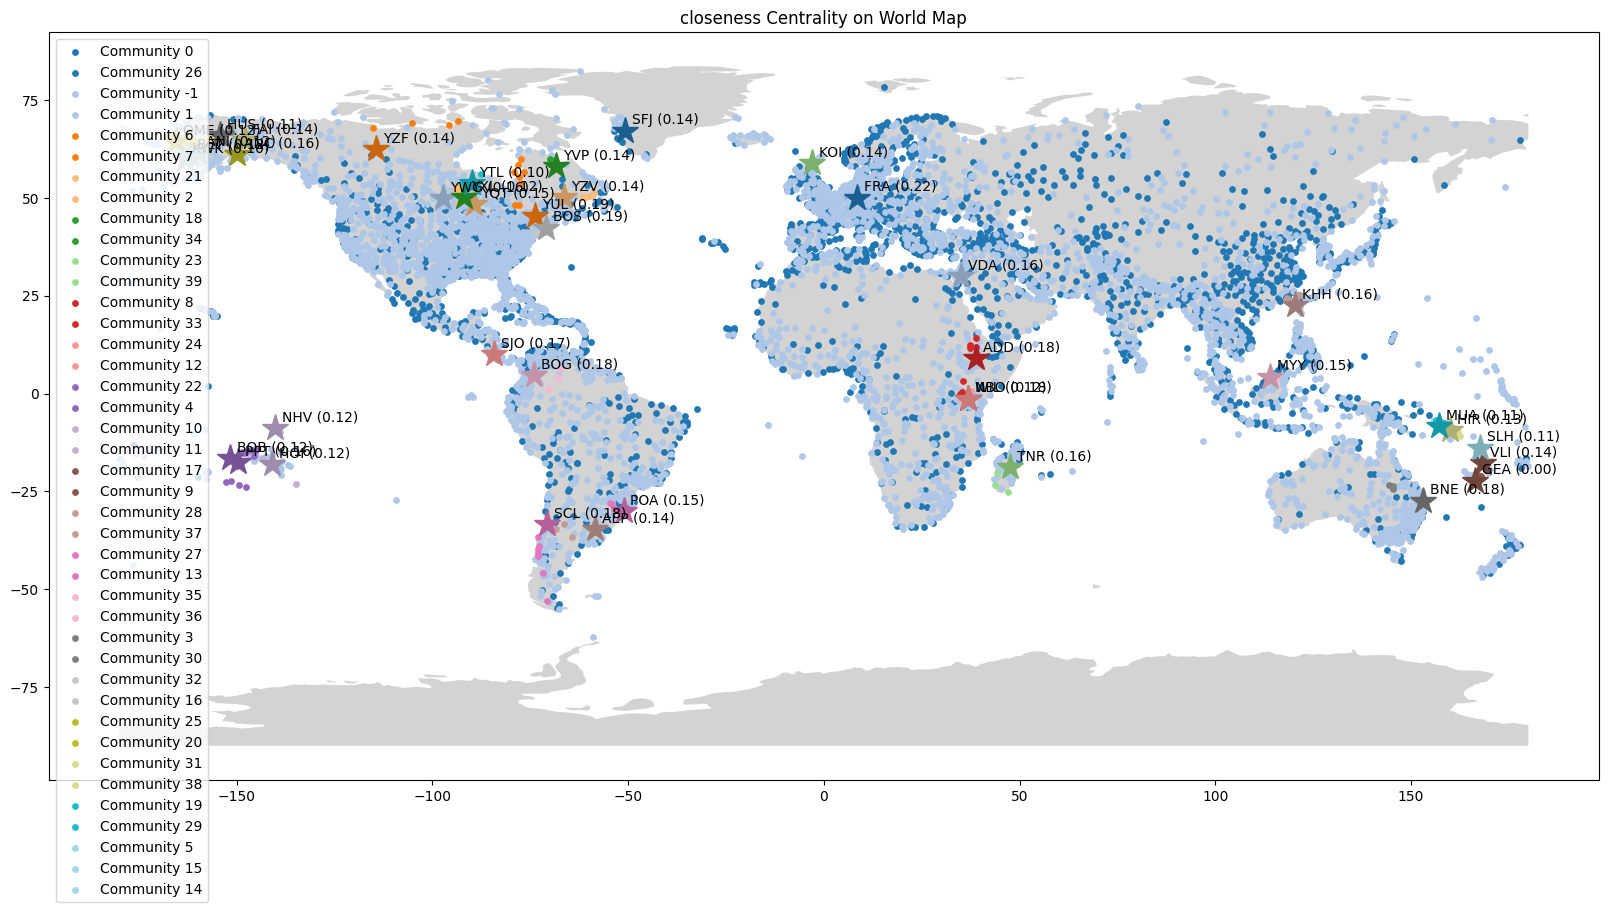

In [34]:
centrality_measures = {
    'closeness': closeness_centrality,
}

for centrality_name, centrality_data in centrality_measures.items():
    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=(20, 12))
    world.plot(ax=ax, color='lightgray')  # Plot world map in the background

    # Plot all nodes, colored by community
    for community, color in community_colors.items():
        subset = gdf[gdf['community'] == community]
        subset.plot(ax=ax, marker='o', color=color, markersize=15, label=f"Community {community}")

    # Find and plot the central node for each community based on the current centrality measure
    for community, color in community_colors.items():
        community_nodes = df[df['community'] == community].Node.tolist()
        max_centrality = 0
        central_node = None
        for node in community_nodes:
            if centrality_data[node] > max_centrality:
                max_centrality = centrality_data[node]
                central_node = node

        if central_node:
            central_node_data = df[df.Node == central_node]
            ax.plot(central_node_data['longitude'], central_node_data['latitude'],
                    marker='*', markersize=20, linestyle='None', color=darken_color(color),
                    )
            ax.annotate(f'{central_node} ({max_centrality:.2f})',
                        (central_node_data['longitude'].iloc[0], central_node_data['latitude'].iloc[0]),
                        textcoords="offset points", xytext=(5,5), ha='left')


    # Add legend and show plot
    plt.legend()
    plt.title(f"{centrality_name} Centrality on World Map")
    plt.show()